# **Import libraries and set random seed**

In [1]:
import time
t = time.time()
import string
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import nltk, re, time
from nltk.corpus import stopwords
# from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


In [2]:
# np_rand_seed = random.randint(0,100)
# tf_rand_seed = random.randint(0,100)
np_rand_seed = 44
tf_rand_seed = 40
np.random.seed(np_rand_seed)
tf.set_random_seed(tf_rand_seed)
print("numpy random seed: ",np_rand_seed)
print("tensorflow random seed: ", tf_rand_seed)

numpy random seed:  44
tensorflow random seed:  40


# **Loading and inspecting the data**

In [3]:
data = pd.read_csv("../input/train.tsv", delimiter="\t")
test_data = pd.read_csv("../input/test.tsv", delimiter="\t")

In [4]:
data.head(10)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma..."
6,6,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...
7,7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...
8,8,Girls Nike Pro shorts,3,Sports & Outdoors/Apparel/Girls,Nike,19.0,0,Girls Size small Plus green. Three shorts total.
9,9,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,NaN,8.0,0,I realized his pants are on backwards after th...


In [5]:
test_data.head(10)

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...
5,5,iPhone 6 Plus or 6s Plus Vodka pink case,1,"Electronics/Cell Phones & Accessories/Cases, C...",NaN,1,One Absolut Vodka in Pink for iPhone 6 Plus an...
6,6,Vintage Cameo Pendant & Brooch Pin,3,Women/Jewelry/Necklaces,Vintage,1,Two vintage Cameo pieces. 1. Silver metal Lock...
7,7,Rose Gold Stainless Steel Quartz Watch,1,Women/Women's Accessories/Watches,NaN,1,Brand new Price firm No trades Box included wi...
8,8,Daisy Marc Jacobs 3.4oz,3,Beauty/Fragrance/Women,MARC JACOBS,0,Brand new No box 100% authentic Firm price NO ...
9,9,Rose Brushes and Silicone Sponge,1,Beauty/Tools & Accessories/Makeup Brushes & Tools,NaN,1,All new. 12 pcs makeup brushes and one Silicon...


In [6]:
data.shape

(1482535, 8)

In [7]:
test_data.shape

(693359, 7)

# **Feature Engineering**

In [8]:
# data['brand_name'] = data['brand_name'].fillna("Nobrand")
# test_data['brand_name'] = test_data['brand_name'].fillna("Nobrand")

In [9]:
# brand_name = pd.concat((data['brand_name'], test_data['brand_name']), axis=0)
# label_encoder = LabelBinarizer()
# label_encoder.fit(brand_name)
# brand_label_encoded_train = label_encoder.transform(data['brand_name'])
# brand_label_encoded_test = label_encoder.transform(test_data['brand_name'])

In [10]:
# print("Shape of brand_label_encoded_train:",brand_label_encoded_train.shape)
# print("Shape of brand_label_encoded_test:",brand_label_encoded_test.shape)

In [11]:
sw = set(stopwords.words("english"))
# stemmer = SnowballStemmer("english")
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))

## **Clean Text**

In [12]:
def clean_text(text):
    '''a function for removing punctuation'''
    
    text = str(text)
    
    # replacing the punctuations with no space,which in effect deletes the punctuation marks 
    text = text.translate(translator)
    
    # remove stop word
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    text = " ".join(text)
    
    # stemming
#     text = [stemmer.stem(word) for word in text.split()]
#     text = " ".join(text) 
    
    # Clean the text
    text = re.sub(r"<br />", " ", text)
    text = re.sub(r"[^a-z]", " ", text)
    text = re.sub(r"   ", " ", text) # Remove any extra spaces
    text = re.sub(r"  ", " ", text)
    
    return(text)

In [13]:
t1 = time.time()
data['name'] = data['name'].apply(clean_text)
print("Finished cleaning the name of train set.", "Time needed:", time.time()-t1)
t2 = time.time()
data['category_name'] = data['category_name'].apply(clean_text)
print("Finished cleaning the catogory name of train set.", "Time needed:", time.time()-t2)
t3 = time.time()
data['item_description'] = data['item_description'].apply(clean_text)
print("Finished cleaning the description of train set","Time needed:", time.time()-t3)

Finished cleaning the name of train set. Time needed: 15.083223581314087
Finished cleaning the catogory name of train set. Time needed: 14.522043704986572
Finished cleaning the description of train set Time needed: 40.401880741119385


In [14]:
t1 = time.time()
test_data['name'] = test_data['name'].apply(clean_text)
print("Finished cleaning the name of train set.", "Time needed:", time.time()-t1)
t2 = time.time()
test_data['category_name'] = test_data['category_name'].apply(clean_text)
print("Finished cleaning the catogory name of train set.", "Time needed:", time.time()-t2)
t3 = time.time()
test_data['item_description'] = test_data['item_description'].apply(clean_text)
print("Finished cleaning the description of train set","Time needed:", time.time()-t3)

Finished cleaning the name of train set. Time needed: 6.92141580581665
Finished cleaning the catogory name of train set. Time needed: 6.820892810821533
Finished cleaning the description of train set Time needed: 19.3880295753479


## **Tokenize Text**

In [15]:
all_description = pd.concat((data['item_description'], test_data['item_description']),axis=0)
tokenizer1 = Tokenizer()
tokenizer1.fit_on_texts(all_description)
del(all_description)

In [16]:
description = tokenizer1.texts_to_sequences(data['item_description'])
print("train description is complete.")
description_test = tokenizer1.texts_to_sequences(test_data['item_description'])
print("test description is complete")

train description is complete.
test description is complete


In [17]:
max_length = 120
description = pad_sequences(description, maxlen = max_length)
print("train decription pad is complete.")
description_test = pad_sequences(description_test, maxlen = max_length)
print("test decription pad is complete.")

train decription pad is complete.
test decription pad is complete.


In [18]:
all_name = pd.concat((data['name'], test_data['name']),axis=0)
tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(all_name)
del(all_name)

In [19]:
name = tokenizer2.texts_to_sequences(data['name'])
print("train name is complete.")
name_test = tokenizer2.texts_to_sequences(test_data['name'])
print("test name is complete")

train name is complete.
test name is complete


In [20]:
max_length = 15
name = pad_sequences(name, maxlen = max_length)
print("train name pad is complete.")
name_test = pad_sequences(name_test, maxlen = max_length)
print("test name pad is complete.")

train name pad is complete.
test name pad is complete.


In [21]:
all_category = pd.concat((data['category_name'], test_data['category_name']),axis=0)
tokenizer3 = Tokenizer()
tokenizer3.fit_on_texts(all_category)
del(all_category)

In [22]:
category = tokenizer3.texts_to_sequences(data['category_name'])
print("train category is complete.")
category_test = tokenizer3.texts_to_sequences(test_data['category_name'])
print("test category is complete")

train category is complete.
test category is complete


In [23]:
max_length = 15
category = pad_sequences(category, maxlen = max_length)
print("train category pad is complete.")
category_test = pad_sequences(category_test, maxlen = max_length)
print("test category pad is complete.")

train category pad is complete.
test category pad is complete.


In [24]:
extra_data = data[['item_condition_id','shipping']].as_matrix()
extra_data_test = test_data[['item_condition_id','shipping']].as_matrix()
price = data['price'].as_matrix()
test_id = test_data['test_id'].as_matrix()

In [25]:
del(data, test_data)

# **Create RNN for the 3 sequences**

In [26]:
tf.reset_default_graph()

In [27]:
n_words1 = len(tokenizer1.word_index)+1
n_words2 = len(tokenizer2.word_index)+1
n_words3 = len(tokenizer3.word_index)+1
embed_size1 = 60
embed_size2 = 10
embed_size3 = 10
n_neurons1 = 60
n_neurons2 = 10
n_neurons3 = 10
name_1 = "1"
name_2 = "2"
name_3 = "3"
n_layers = 2
rnn_dropout = tf.placeholder(tf.float32)

In [28]:
def build_rnn(inputs, n_words, embed_size, n_neurons, n_layers, name):
    
    # placeholders for embeddings
    with tf.variable_scope("embedding"+name):
        embedding = tf.Variable(tf.truncated_normal((n_words, embed_size), -0.1, 0.1))
#         padding_zeros = tf.zeros(shape=[embed_size])
#         embedding = tf.concat(0, [[padding_zeros], embedding])
        embed = tf.nn.embedding_lookup(embedding, inputs, validate_indices=False)

    with tf.variable_scope("rnn"+name):
        lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
                      for layer in range(n_layers)]
        multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)
        output, state = tf.nn.dynamic_rnn(multi_cell, embed, dtype=tf.float32)
        top_layer_h_state = state[-1][1]
        
    return top_layer_h_state

In [29]:
input1 = tf.placeholder(tf.int32, [None, None])
rnn_output1 = build_rnn(input1, n_words1, embed_size1, n_neurons1, n_layers, name_1)
rnn_output1

<tf.Tensor 'rnn1/rnn/while/Exit_6:0' shape=(?, 60) dtype=float32>

In [30]:
input2 = tf.placeholder(tf.int32, [None, None])
rnn_output2 = build_rnn(input2, n_words2, embed_size2, n_neurons2, n_layers, name_2)
rnn_output2

<tf.Tensor 'rnn2/rnn/while/Exit_6:0' shape=(?, 10) dtype=float32>

In [31]:
input3 = tf.placeholder(tf.int32, [None, None])
rnn_output3 = build_rnn(input3, n_words3, embed_size3, n_neurons3, n_layers, name_3)
rnn_output3

<tf.Tensor 'rnn3/rnn/while/Exit_6:0' shape=(?, 10) dtype=float32>

In [32]:
rnn_output_combined = tf.concat((rnn_output1, rnn_output2, rnn_output3), axis=1)
rnn_output_combined

<tf.Tensor 'concat:0' shape=(?, 80) dtype=float32>

# **Create Fully Connected Layers**

In [33]:
input4 = tf.placeholder(tf.float32, [None, 2])
prices = tf.placeholder(tf.float32, [None, 1])
keep_prob  = tf.placeholder(tf.float32)

In [34]:
def create_weights(shape):
    '''a function to create weight tensor'''
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
 
def create_biases(size):
    '''a function to create bias tensor'''
    return tf.Variable(tf.constant(0.05, shape=[size]))

In [35]:
def create_fc_layer(input,          
                    num_inputs,    
                    num_outputs,
                    use_sigmoid=True,
                    dropout = False, 
                    keep_prob = 0.8):
    
    '''a function for creating fully connected layer'''
    
    #Let's define trainable weights and biases.
    weights = create_weights(shape=[num_inputs, num_outputs])
    biases = create_biases(num_outputs)
    
    # matrix multiplication between input and weight matrix
    layer = tf.matmul(input, weights) + biases
    
    # add relu activation if wanted
    if use_sigmoid:
        layer = tf.nn.sigmoid(layer)
        
    # if dropout is wanted add dropout
    if dropout:        
        layer = tf.nn.dropout(layer, keep_prob)
    
    # return layer
    return layer

In [36]:
fc_size1 = 25
fc_size2 = 5
fc_size3 = 5

In [37]:
fully_connected_layer1 = create_fc_layer(rnn_output_combined,
                                         rnn_output_combined.get_shape()[1].value,
                                         fc_size1,
                                         use_sigmoid = True,
                                         dropout = True,
                                         keep_prob = keep_prob)
fully_connected_layer1

<tf.Tensor 'dropout/mul:0' shape=(?, 25) dtype=float32>

In [38]:
fully_connected_layer2 = create_fc_layer(input4,
                                         input4.get_shape()[1].value,
                                         fc_size2,
                                         use_sigmoid = True,
                                         dropout = True,
                                         keep_prob = keep_prob)
fully_connected_layer2

<tf.Tensor 'dropout_1/mul:0' shape=(?, 5) dtype=float32>

In [39]:
combined_layer = tf.concat((fully_connected_layer1, fully_connected_layer2), axis=1)
combined_layer

<tf.Tensor 'concat_1:0' shape=(?, 30) dtype=float32>

In [40]:
fully_connected_layer3 = create_fc_layer(combined_layer,
                                         combined_layer.get_shape()[1].value,
                                         fc_size3,
                                         use_sigmoid = True,
                                         dropout = True,
                                         keep_prob = keep_prob)
fully_connected_layer3

<tf.Tensor 'dropout_2/mul:0' shape=(?, 5) dtype=float32>

In [41]:
outputs = create_fc_layer(fully_connected_layer3,
                         fc_size3,
                         1,
                         use_sigmoid = False,
                         dropout = False,
                         keep_prob = keep_prob)
outputs

<tf.Tensor 'add_3:0' shape=(?, 1) dtype=float32>

In [42]:
loss = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(tf.log(outputs+1),tf.log(prices+1)))))

In [43]:
# learning rate of optimizer
learning_rate = (1e-1)*5
# train step
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# **Train model**

## **Split data**

In [44]:
train_indices = np.random.choice(len(price), round(len(price)*0.993), replace=False)
validation_indices = np.array(list(set(range(len(price))) - set(train_indices)))

description_train = description[train_indices]
description_validation = description[validation_indices]

name_train = name[train_indices]
name_validation = name[validation_indices]

category_train = category[train_indices]
category_validation = category[validation_indices]

extra_data_train = extra_data[train_indices]
extra_data_validation = extra_data[validation_indices]

price_train = price[train_indices]
price_validation = price[validation_indices]

del(description, name, category, extra_data, price)

In [45]:
print("Shape of description_train:",description_train.shape)
print("Shape of description_validation:",description_validation.shape)
print("Shape of name_train:",name_train.shape)
print("Shape of name_validation:",name_validation.shape)
print("Shape of category_train:",category_train.shape)
print("Shape of category_validation:",category_validation.shape)
print("Shape of extra_data_train:",extra_data_train.shape)
print("Shape of extra_data_validation:",extra_data_validation.shape)
print("Shape of price_train:",price_train.shape)
print("Shape of price_validation:",price_validation.shape)

Shape of description_train: (1472157, 120)
Shape of description_validation: (10378, 120)
Shape of name_train: (1472157, 15)
Shape of name_validation: (10378, 15)
Shape of category_train: (1472157, 15)
Shape of category_validation: (10378, 15)
Shape of extra_data_train: (1472157, 2)
Shape of extra_data_validation: (10378, 2)
Shape of price_train: (1472157,)
Shape of price_validation: (10378,)


In [46]:
# lists to store the train loss, validation loss, validation accuracy at each iteration
train_loss = []
valid_loss = []

# batch size
batch_size = 100
# max iteration
max_iter = 1000

## **Train and save the best model**

In [47]:
# create a saver object
saver = tf.train.Saver(max_to_keep=1)

# variables to store the accuracy, loss, iteration of our best model
best_loss = 1000000
best_iteration = None

iteration = 0

# create a graph session and optimize under it
with tf.Session() as sess:
    
    # initialize variables
    sess.run(tf.global_variables_initializer())

    # while 57 minutes have not elapsed (to finish before the kernel is killed)
    while (time.time()-t) < 45*60:
        
        # break if max iteration is reached
        if iteration >= max_iter:
            break

        # randomly choosing the indices of the batch 
        rand_index = np.random.choice(price_train.shape[0], size=batch_size)

        # extract the batch image and labels
        description_train_rand = description_train[rand_index]
        name_train_rand = name_train[rand_index]
        category_train_rand = category_train[rand_index]
        extra_data_train_rand = extra_data_train[rand_index]
        price_train_rand = price_train[rand_index]

        # feed dictionary for batch
        feed_dict_batch =  {input1: description_train_rand,
                            input2: name_train_rand,
                            input3: category_train_rand,
                            input4: extra_data_train_rand,
                            prices: np.transpose([price_train_rand]),
                            keep_prob: 0.8}
        # feed dictionary for train
        feed_dict_train =  {input1: description_train_rand,
                            input2: name_train_rand,
                            input3: category_train_rand,
                            input4: extra_data_train_rand,
                            prices: np.transpose([price_train_rand]),
                            keep_prob: 1.0}
        # feed dictionary for validation
        feed_dict_validation =  {input1: description_validation,
                                input2: name_validation,
                                input3: category_validation,
                                input4: extra_data_validation,
                                prices: np.transpose([price_validation]),
                                keep_prob: 1.0}
        
        # execute optimization step
        sess.run(train_step, feed_dict=feed_dict_batch)
        
        # calculate temporary train loss and append it to the designated list
        temp_train_loss = loss.eval(session=sess, feed_dict=feed_dict_train)
        train_loss.append(temp_train_loss)
        # calculate temporary validation loss and append it to the designated list
        temp_validation_loss = loss.eval(session=sess, feed_dict=feed_dict_validation)
        valid_loss.append(temp_validation_loss)
        
        if (temp_validation_loss < best_loss):
            best_loss = temp_validation_loss
            best_iteration = iteration           
            saver.save(sess, './my-model', global_step = best_iteration)
            
         # print metric info
        print("iterations:",iteration,
              "| train_loss:", temp_train_loss,
              "| validation_loss:", temp_validation_loss)
        
        # increment iteration
        iteration = iteration+1

iterations: 0 | train_loss: 2.11881 | validation_loss: 1.99242
iterations: 1 | train_loss: 1.60417 | validation_loss: 1.5661
iterations: 2 | train_loss: 1.35205 | validation_loss: 1.31079
iterations: 3 | train_loss: 1.09939 | validation_loss: 1.14063
iterations: 4 | train_loss: 0.947162 | validation_loss: 1.02118
iterations: 5 | train_loss: 0.952319 | validation_loss: 0.935239
iterations: 6 | train_loss: 0.919397 | validation_loss: 0.873605
iterations: 7 | train_loss: 0.800725 | validation_loss: 0.830186
iterations: 8 | train_loss: 0.842457 | validation_loss: 0.799704
iterations: 9 | train_loss: 0.853525 | validation_loss: 0.778859
iterations: 10 | train_loss: 0.864046 | validation_loss: 0.765162
iterations: 11 | train_loss: 0.780449 | validation_loss: 0.756718
iterations: 12 | train_loss: 0.810725 | validation_loss: 0.75205
iterations: 13 | train_loss: 0.73784 | validation_loss: 0.750077
iterations: 14 | train_loss: 0.649818 | validation_loss: 0.74995
iterations: 15 | train_loss: 0.83

iterations: 125 | train_loss: 0.79948 | validation_loss: 0.751096
iterations: 126 | train_loss: 0.794464 | validation_loss: 0.751106
iterations: 127 | train_loss: 0.593325 | validation_loss: 0.751149
iterations: 128 | train_loss: 0.853073 | validation_loss: 0.751192
iterations: 129 | train_loss: 0.600102 | validation_loss: 0.75128
iterations: 130 | train_loss: 0.674824 | validation_loss: 0.751329
iterations: 131 | train_loss: 0.868745 | validation_loss: 0.751379
iterations: 132 | train_loss: 0.796813 | validation_loss: 0.751329
iterations: 133 | train_loss: 0.847438 | validation_loss: 0.751243
iterations: 134 | train_loss: 0.766403 | validation_loss: 0.751124
iterations: 135 | train_loss: 0.723769 | validation_loss: 0.750982
iterations: 136 | train_loss: 0.711914 | validation_loss: 0.750794
iterations: 137 | train_loss: 0.77298 | validation_loss: 0.750581
iterations: 138 | train_loss: 0.713172 | validation_loss: 0.750413
iterations: 139 | train_loss: 0.692281 | validation_loss: 0.75028

iterations: 248 | train_loss: 0.640542 | validation_loss: 0.749823
iterations: 249 | train_loss: 0.7464 | validation_loss: 0.749838
iterations: 250 | train_loss: 0.763075 | validation_loss: 0.749894
iterations: 251 | train_loss: 0.733442 | validation_loss: 0.749984
iterations: 252 | train_loss: 0.712759 | validation_loss: 0.750114
iterations: 253 | train_loss: 0.716416 | validation_loss: 0.750255
iterations: 254 | train_loss: 0.825731 | validation_loss: 0.750341
iterations: 255 | train_loss: 0.661438 | validation_loss: 0.750452
iterations: 256 | train_loss: 0.668163 | validation_loss: 0.750636
iterations: 257 | train_loss: 0.729028 | validation_loss: 0.750771
iterations: 258 | train_loss: 0.735556 | validation_loss: 0.750823
iterations: 259 | train_loss: 0.797433 | validation_loss: 0.750795
iterations: 260 | train_loss: 0.772038 | validation_loss: 0.750817


In [48]:
print("Best loss:", best_loss)

Best loss: 0.749823


## **Compute predictions for test set**

In [49]:
with tf.Session() as sess:  
    
    t_start = time.time()
    
    # restore the best model
    model_path = "./"+"my-model-"+str(best_iteration)
    saver.restore(sess, model_path)
    
    # break the test set into k folds other wise kernel will be out of memory
    n = len(test_id)
    k = 100
    step = n//k
    
    # array to store the prediction
    preds = np.array([])

    # iterate through each fold
    for i in range(k):

        # start and end indices of the fold
        if i != (k-1):
            start = (step*i)
            end = (step*(i+1)) 
        else:
            start = (step*i)
            end = len(test_id)

        # feed dictionary for the fold
        feed_dict_test =  {input1: description_test[start:end],
                            input2: name_test[start:end],
                            input3: category_test[start:end],
                            input4: extra_data_test[start:end],
                            keep_prob: 1.0}

        # evaluate predictions of the fold
        fold_preds = outputs.eval(session=sess, feed_dict = feed_dict_test)
        # append the predictions of the fold to the designated array
        preds = np.append(preds, fold_preds)
        
        print("Computed predictions for fold",i)
    
    # save the submission csv file
    submission_path = "./sample_submission.csv"
    submission = pd.DataFrame({"test_id ": test_id, "price": preds})
    submission.to_csv(submission_path, header = True, index=False)
    
    print("Time required to compute prediction:", time.time()-t_start)

INFO:tensorflow:Restoring parameters from ./my-model-248
Computed predictions for fold 0
Computed predictions for fold 1
Computed predictions for fold 2
Computed predictions for fold 3
Computed predictions for fold 4
Computed predictions for fold 5
Computed predictions for fold 6
Computed predictions for fold 7
Computed predictions for fold 8
Computed predictions for fold 9
Computed predictions for fold 10
Computed predictions for fold 11
Computed predictions for fold 12
Computed predictions for fold 13
Computed predictions for fold 14
Computed predictions for fold 15
Computed predictions for fold 16
Computed predictions for fold 17
Computed predictions for fold 18
Computed predictions for fold 19
Computed predictions for fold 20
Computed predictions for fold 21
Computed predictions for fold 22
Computed predictions for fold 23
Computed predictions for fold 24
Computed predictions for fold 25
Computed predictions for fold 26
Computed predictions for fold 27
Computed predictions for fold

## **Plot of vs iterations**

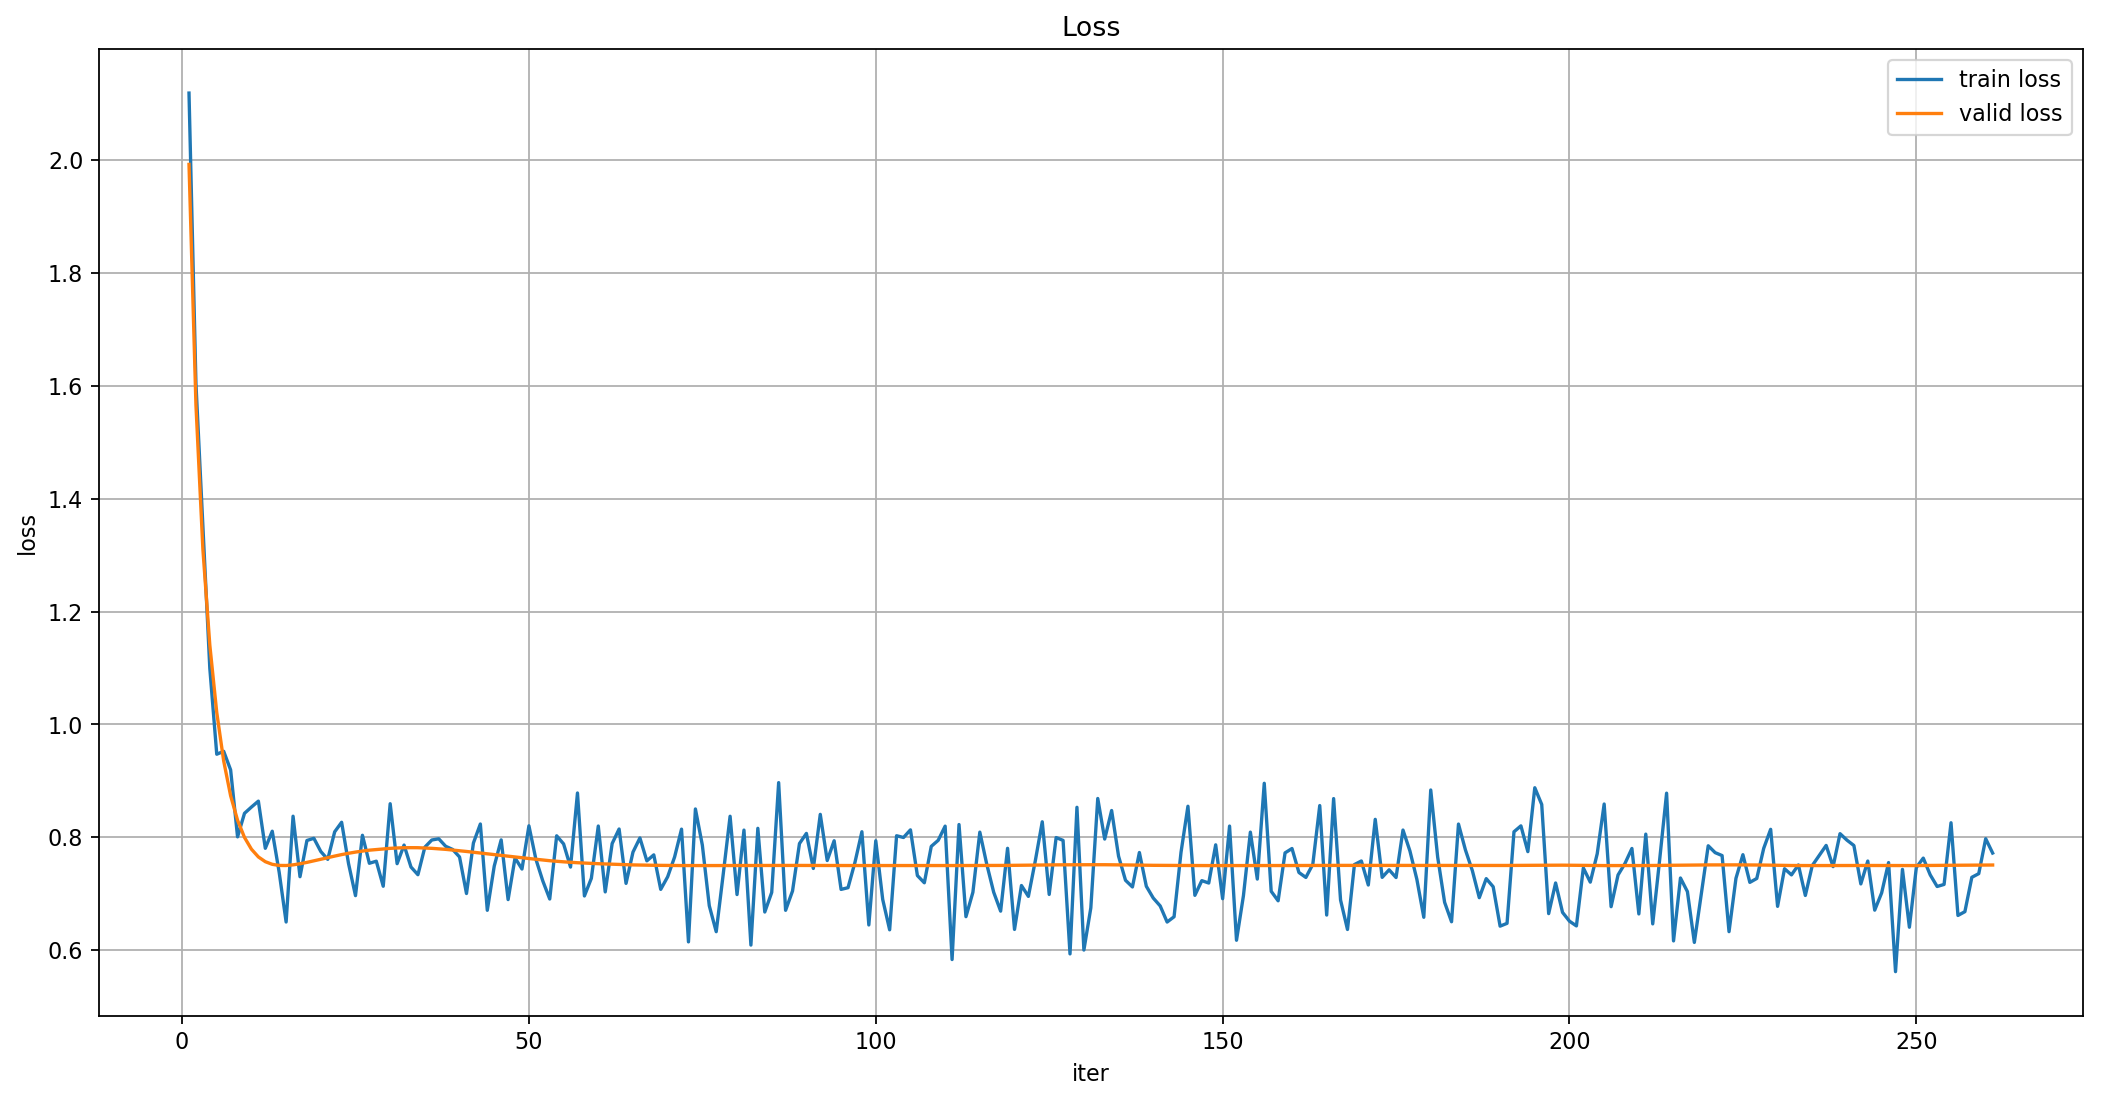

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
iterations = list(range(1,iteration+1))
plt.plot(iterations, train_loss, label = "train loss")
plt.plot(iterations, valid_loss, label = "valid loss")
plt.title("Loss")
plt.xlabel("iter")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()